<a href="https://colab.research.google.com/github/JonHaz/Ethereum/blob/main/Craft_a_Story_from_a_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's look at Ethereum Blck Data for the month of January

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [4]:
# Save output in a variable `df`

%%bigquery --project storied-sound-253213 df
SELECT
   timestamp, number, miner, difficulty, size, transaction_count,
FROM `bigquery-public-data.crypto_ethereum.blocks` 
WHERE DATE(timestamp) BETWEEN "2021-01-21" AND "2021-01-31"

In [9]:
df.head()

,timestamp,number,miner,difficulty,size,transaction_count
0,2021-01-29 09:18:14+00:00,11749940,0xe9b54a47e3f401d37798fc4e22f14b78475c2afc,4419619822668506,58169,272
1,2021-01-29 08:36:10+00:00,11749764,0x2f731c3e8cd264371ffdb635d07c14a6303df52a,4463200856626051,33800,134
2,2021-01-29 09:21:28+00:00,11749956,0x2f731c3e8cd264371ffdb635d07c14a6303df52a,4423931118902302,59872,300
3,2021-01-29 02:09:01+00:00,11748026,0x2f731c3e8cd264371ffdb635d07c14a6303df52a,4519910012666365,50711,258
4,2021-01-29 15:25:20+00:00,11751570,0x2f731c3e8cd264371ffdb635d07c14a6303df52a,4342965767206927,55415,267


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71465 entries, 0 to 71464
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   timestamp          71465 non-null  datetime64[ns, UTC]
 1   number             71465 non-null  int64              
 2   miner              71465 non-null  object             
 3   difficulty         71465 non-null  object             
 4   size               71465 non-null  int64              
 5   transaction_count  71465 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(3), object(2)
memory usage: 3.3+ MB


First let's analyze the columns 'size' and 'transaction_count'

In [17]:
df[['size','transaction_count']].describe()

,size,transaction_count
count,71465.000000,71465.000000
mean,44250.298174,183.449157
std,11875.228608,63.321700
min,518.000000,0.000000
25%,38987.000000,148.000000
50%,44818.000000,181.000000
75%,50330.000000,215.000000
max,205974.000000,595.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d9b3f8310>,
      dtype=object)

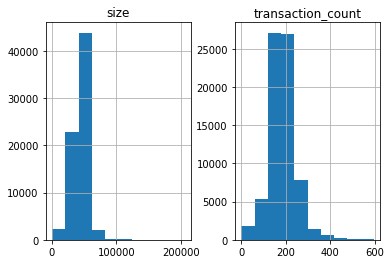

In [16]:
df[['size','transaction_count']].hist()

In [18]:
df[['size','transaction_count']].corr()

,size,transaction_count
size,1.000000,0.588667
transaction_count,0.588667,1.000000


How many miners do we have during this period?

In [26]:
df['miner'].groupby(df['miner']).count().sort_values(ascending=False).count()

91

The top 10% of Miners make up 82% of the the blocks during this month

```
# This is formatted as code
```



In [39]:
blocks = df['miner'].groupby(df['miner']).count().sort_values(ascending=False)

top_9 = blocks.nlargest(9)
top_9.sum()

top_9.sum()/blocks.sum()

0.8242076540964108

In terms of number of blocks what does that distribution look like?

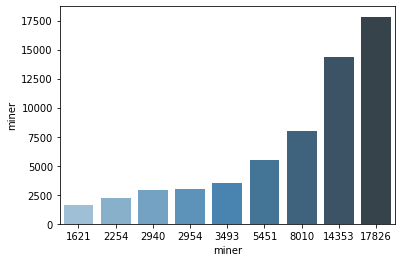

In [57]:

import seaborn as sns
import matplotlib.pyplot as plt

x=top_9.index
y = top_9

sns.barplot(x=x, y=y, data=blocks,
            label="Total", palette="Blues_d")